# 15.777 Homework 3: Vision Transformer Networks


In [ ]:
# basic python imports and packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import json

In [ ]:
# install the latest version of keras and keras-hub
!!pip install -q git+https://github.com/keras-team/keras-hub.git
!!pip install -q --upgrade keras  # Upgrade to Keras 3.

[]

In [ ]:
# deep learning imports and packages
os.environ["KERAS_BACKEND"] = "jax"
import keras
# from keras import losses
# from keras import ops
# from keras import optimizers
# from keras.optimizers import schedules
# from keras.applications.imagenet_utils import decode_predictions
# from keras.layers import Dropout, Dense, GlobalAveragePooling1D, Flatten, Lambda
import keras_hub

# Import tensorflow for `tf.data` and its preprocessing functions
import tensorflow as tf

# initialize the seeds of different random number generators so that the
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

## Make sure GPU is loaded correctly


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  print("Successfully loaded GPU!")


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sat Mar  8 21:17:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             49W /  400W |   30829MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

<font color='red'> **Please be sure to make a copy of this notebook in your own Google Drive so that your work is saved!** </font>

# Introduction

Your goal in this exercise is to detect emotion from a facial image. To that end, we will use the 2013 Facial Expression Recognition (FER) dataset.

The dataset consists of ~36,000 images, each annotated with one of seven labels:
* angry
* disgust
* fear
* happy
* sad
* surprise
* neutral

The goal of this homework assignment is to walk you through how to:

1. Use transfer learning with a Vision Transformer (ViT) model to detect emotion in facial images (Problems 1 and 2)
2. Compare transfer learning with training a model from scratch (Problem 3)

This assignment will help you understand the importance of pre-trained models and fine-tuning strategies when working with transformer-based architectures.

But first, let's get the data.

In [ ]:

# download the dataset
!wget -q -O fer2013.csv -P ./ "https://dl.dropbox.com/scl/fi/e2ik6aryemboameq1rwwn/fer2013.csv?rlkey=ux7tyge6flk9nnuul9desizgf&dl=0"

The data has 35887 rows and 3 columns:
* Emotion - encoded as the numbers 0 (anger) through 6 (neutral)
* Pixels - A space-separated list of numbers representing the pixels of this image.
* Usage - No need to worry about this column

In [ ]:
data = pd.read_csv('fer2013.csv')
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


The pixel values for each image is provided as a space-separated list of numbers. How many pixels in an image?

In [ ]:
len(data.loc[0, 'pixels'].split(' '))

2304

### Pre-Processing the Pixels (Independent Variable)

Each image is encoded as a list of 2304 pixels. We will reshape this into an 48x48 image next.

Recall that a color image is represented as a tensor of dimension N by M by 3, where the 3 represents the 3 color channels (red, green and blue). Our images from the FER 2013 dataset are grayscale images, with only a single channel representing the amount of black in the image. This is inconvenient to work with because many pre-trained models used in transfer learning, such as the one we will use in Problem 4, require the input image to have 3 channels.

To get around this, we will take each image, a 48 x 48 tensor and transform it into a 48 x 48 x 3 tensor by simply duplicating it three times. We can think of a greyscale image is one where the red, green and blue color channels are exactly the same.

The following code transforms our dataset into a tensor of shape (35887, 48, 48, 3): a list of 35887 images, each of which are a (48, 48, 3)-shape tensor.

In [ ]:
pixels = data['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')] # read each face as a 1-d array
    face = np.asarray(face).reshape(width, height) # reshape the length 2304 1-d array into an 48x48 array
    face = np.stack((face,)*3, axis=-1)
    faces.append(face.astype('float32'))

faces = np.asarray(faces)
faces.shape

(35887, 48, 48, 3)

For the first image, i.e. `faces[0]`, we can examine its first channel (corresponding to "red").

In [ ]:
faces[0, :, :, 0]

array([[ 70.,  80.,  82., ...,  52.,  43.,  41.],
       [ 65.,  61.,  58., ...,  56.,  52.,  44.],
       [ 50.,  43.,  54., ...,  49.,  56.,  47.],
       ...,
       [ 91.,  65.,  42., ...,  72.,  56.,  43.],
       [ 77.,  82.,  79., ..., 105.,  70.,  46.],
       [ 77.,  72.,  84., ..., 106., 109.,  82.]], dtype=float32)

This is the exact same as the second channel (corresponding to "blue"). And similarly for green.

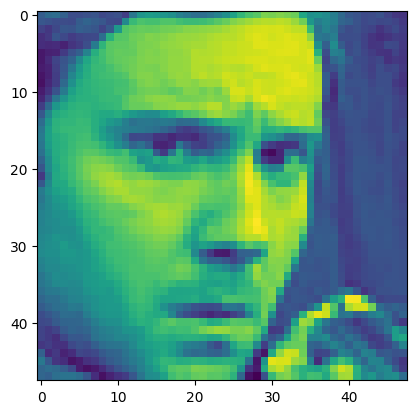

array([[ 70.,  80.,  82., ...,  52.,  43.,  41.],
       [ 65.,  61.,  58., ...,  56.,  52.,  44.],
       [ 50.,  43.,  54., ...,  49.,  56.,  47.],
       ...,
       [ 91.,  65.,  42., ...,  72.,  56.,  43.],
       [ 77.,  82.,  79., ..., 105.,  70.,  46.],
       [ 77.,  72.,  84., ..., 106., 109.,  82.]], dtype=float32)

In [ ]:
# show image
plt.imshow(faces[0, :, :, 1].astype('uint8'))
plt.show()
faces[0, :, :, 1]

### Pre-Processing for Emotions (Dependent Variable)

Next, let's take a look at how emotion (the dependent variable) is encoded. We have that 0 = 'angry', 1 = 'disgust', ... 6 = 'neutral'.

In [ ]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

We will convert emotion to a one-hot encoding using the `pd.get_dummies` function.

In [ ]:
emotions = pd.get_dummies(data['emotion']).to_numpy() # each emotion is 'one-hot' encoded as a 7-dim vector
emotions_names = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
emotions.shape

(35887, 7)

### Example Images
Lets take a look at some of these fun images!

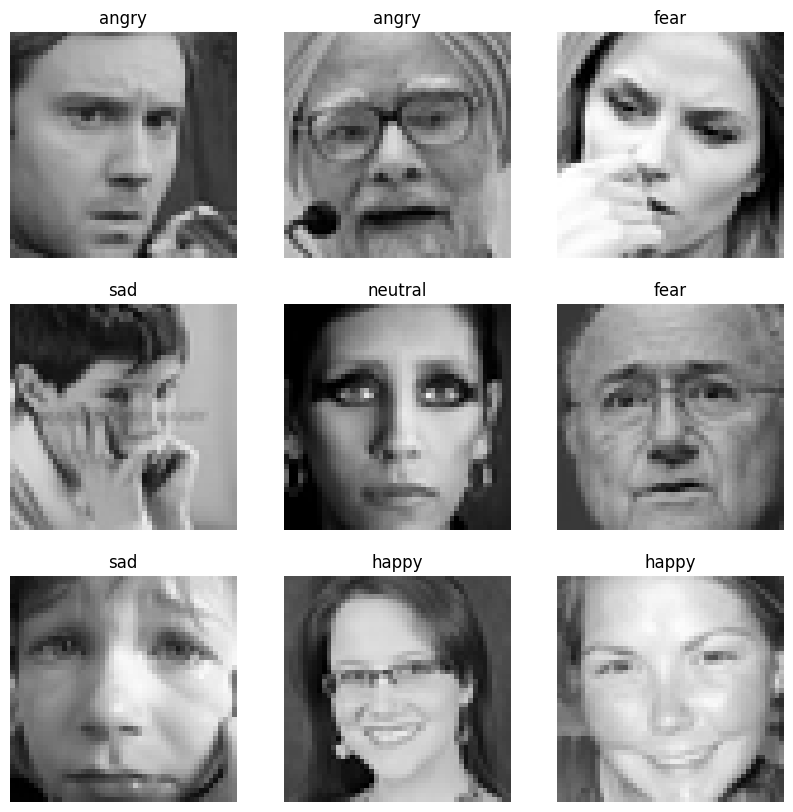

In [ ]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_title(f"{emotions_names[np.argmax(emotions[i])]}")
    ax.imshow(faces[i].astype('uint8'))
    ax.axis('off')

### Train/Test Split
As in the original dataset, we will reserve the first 28,709 images for training and the rest for testing.

In [ ]:
train_faces, train_emotions =  faces[:28709], emotions[:28709]
test_faces, test_emotions =  faces[28709:], emotions[28709:]

train_faces.shape, train_emotions.shape, test_faces.shape, test_emotions.shape

((28709, 48, 48, 3), (28709, 7), (7178, 48, 48, 3), (7178, 7))

# Problem 1: Transfer Learning with Frozen Vision Transformer Model [30 Points]
In this problem, we will build an emotion classifier using a pre-trained Vision Transformer backbone with a custom classification head. We'll keep the backbone frozen and only train the classification head.


## [OPTIONAL] Enable testing for initial experiments to save Compute Credits
The below code is useful if you want to experiment quickly with a smaller partition of the dataset before you finalize your code.

Please set the `pcnt_sample` parameter to a value between 0 and 1 (0% to 100% of the dataset) to reduce the training size, or set the `test_run` variable to `False/True` respectively.

In [ ]:
# randomly sample X% of training data for faster training
pcnt_sample = 0.5
epochs=5
test_run = False  # set to False to train on the entire dataset
if test_run:
    train_size = len(train_faces)
    test_size = len(test_faces)
    # random indices for sampling
    np.random.seed(42)
    n_train_samples = int(train_size * pcnt_sample)
    n_test_samples = int(test_size * pcnt_sample)
    train_indices = np.random.choice(train_size, n_train_samples, replace=False)
    test_indices = np.random.choice(test_size, n_test_samples, replace=False)
    print(f"Training on {n_train_samples}/{train_size} ({pcnt_sample*100}%) samples")
    # sample both features and labels using same indices
    train_faces = train_faces[train_indices]
    train_emotions = train_emotions[train_indices]
    test_faces = test_faces[test_indices]
    test_emotions = test_emotions[test_indices]

## Part (a): Building the Model [10 points]
We'll use the ViT backbone with a classification head for 7 emotion classes.
The backbone is pre-trained on ImageNet, and we'll focus on training just the classification head.


In [ ]:
# Load the ViT backbone and preprocessor
# load weights is set to False because we will train the model from scratch
backbone = keras_hub.models.Backbone.from_preset("vit_base_patch16_224_imagenet")
preprocessor = keras_hub.models.ViTImageClassifierPreprocessor.from_preset("vit_base_patch16_224_imagenet")

**Hint**: Refer to the Lecture 8 Colab

In [ ]:
# Define data augmentation pipeline
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomTranslation(0.1, 0.1),
])

# Create the model
inputs = keras.Input(shape=(48, 48, 3), name="input")
#######################
x = data_augmentation(inputs)                             # Apply data augmentation
x = preprocessor(x)                                       # Preprocess input for ViT
x = backbone(x)[:, 0, :]                                  # Run through ViT backbone, select CLS embedding
x = keras.layers.Dense(256, activation="relu")(x)         # Run through a dense layer
outputs = keras.layers.Dense(7, activation="softmax")(x)  # Final classification layer

# Create the model
model = keras.Model(inputs, outputs)


#######################
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_image_classifier_preprocessor   │ (None, 224, 224, 3)         │               0 │
│ (ViTImageClassifierPreprocessor)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_backbone (ViTBackbone)          │ (None, 197, 768)            │      85,798,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_1 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,997,319 (328.05 MB)

 Trainable params: 85,997,319 (328.05 MB)

 Non-trainable params: 0 (0.00 B)


## Part (b): Number of Parameters [10 points]
Explain how many parameters the model contains. How many trainable? How many non-trainable?

85,997,319 - all trainable. No non-trainable params

## Part (c): Training and Evaluation [10 points]

Let us compile our model and fit it on the training data. Since we one-hot-encoded the dependent variable, we use `categorical_crossentropy`, not `sparse_categorical_crossentropy`.

Fill in the parameters of `model.compile` and `model.fit` below.

* Compile the model using the `categorical_crossentropy` loss, `adam` optimizer and report the `accuracy` metric.
* Fit the model on `train_faces`, `train_emotions` using a batch size of 64, for 5 epochs and a validation split of 20%.
* Use `learning_rate=1e-4`

In [ ]:
# Freeze the backbone
backbone.trainable = False

model.summary()

model.compile(
#######################
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
#######################
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_image_classifier_preprocessor   │ (None, 224, 224, 3)         │               0 │
│ (ViTImageClassifierPreprocessor)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_backbone (ViTBackbone)          │ (None, 197, 768)            │      85,798,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_1 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,997,319 (328.05 MB)

 Trainable params: 198,663 (776.03 KB)

 Non-trainable params: 85,798,656 (327.30 MB)

In [ ]:
model_history = model.fit(
#######################
    train_faces,
    train_emotions,
    epochs=5,
    batch_size=64,
    validation_split=0.2
#######################
)

Epoch 1/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 180s 471ms/step - accuracy: 0.3642 - loss: 1.6629 - val_accuracy: 0.5242 - val_loss: 1.3078
Epoch 2/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 159s 444ms/step - accuracy: 0.4738 - loss: 1.3721 - val_accuracy: 0.5406 - val_loss: 1.2535
Epoch 3/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 159s 444ms/step - accuracy: 0.4951 - loss: 1.3204 - val_accuracy: 0.5700 - val_loss: 1.1774
Epoch 4/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 158s 441ms/step - accuracy: 0.5157 - loss: 1.2850 - val_accuracy: 0.5752 - val_loss: 1.1632
Epoch 5/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 158s 441ms/step - accuracy: 0.5178 - loss: 1.2653 - val_accuracy: 0.5848 - val_loss: 1.1541


**Plotting the Training/Validation Accuracy Curve**

Use the `plot_accuracy` function below to plot the training and validation accuracy across the training epochs.

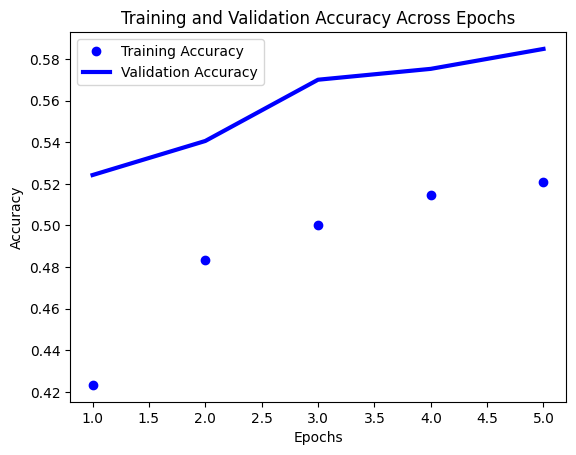

In [ ]:
def plot_accuracy(model_history):
    history_dict = model_history.history
    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "bo", label="Training Accuracy", linewidth=3)
    plt.plot(epochs, val_acc, "b", label="Validation Accuracy", linewidth=3)
    plt.title("Training and Validation Accuracy Across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_accuracy(model_history)

# Calculate test accuracy

In [ ]:
test_loss, test_accuracy = model.evaluate(test_faces, test_emotions)
print(f"Test accuracy: {test_accuracy:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 57s 237ms/step - accuracy: 0.1100 - loss: 2.4187
Test accuracy: 0.1110


Let's also calculate the confusion matrix and the accuracy on the test set.

The function `show_confusion_matrix` has been written for you below. You can apply it to any Keras Model and it will calculate:
* Test accuracy
* A confusion matrix. Recall that each row of the confusion matrix are the actual labels and each column are the predictions. For example, if element in row `happy` and column `sad` is 250, then there are 250 data points in the test set where the true label is `happy` but we predicted `sad`.
* A heatmap of the confusion matrix, where each row is normalized to add up to 1.0. For example, if element in row `happy` and column `sad` is 0.25, then that means 25% of data points with a true label of `happy` were predicted as `sad`.

225/225 ━━━━━━━━━━━━━━━━━━━━ 46s 207ms/step
*************************
* Test Accuracy: 0.1110 *
*************************


,angry,disgust,fear,happy,sad,surprise,neutral
angry,26,293,21,125,128,9,356
disgust,3,44,4,8,16,0,36
fear,9,309,22,95,102,13,474
happy,15,1077,97,158,143,9,275
sad,32,378,28,126,61,17,605
surprise,2,217,6,171,94,2,339
neutral,15,453,76,135,63,7,484


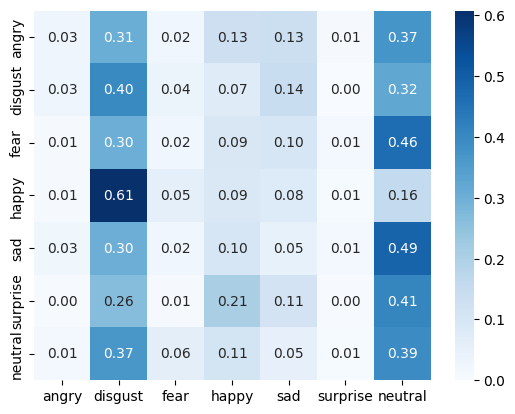

In [ ]:
from IPython.display import display

def show_confusion_matrix(model):
    """
    Calculates the test accuracy, confusion matrix and heat map for a model.
    """
    global test_faces, test_emotions, emotions_names

    y_pred = model.predict(test_faces).argmax(axis=1)
    y_actual = test_emotions.argmax(axis=1)

    print('*************************\n* Test Accuracy: %.4f *\n*************************' % metrics.accuracy_score(y_actual, y_pred))

    cm = pd.DataFrame(metrics.confusion_matrix(y_actual, y_pred), index=emotions_names, columns=emotions_names)
    display(cm)

    cm = cm.div(cm.sum(axis=1), axis=0)

    sns.heatmap(cm, cmap="Blues", annot=True, fmt=".2f")

show_confusion_matrix(model)

Please comment briefly on the model's performance.

<font color='red'> **Your Answer** </font>

With a test accuracy of 56%, this model has a low performance. However, it is higher than the baseline (1 out of 7 or 14%)

# Problem 2: Transfer Learning with Fine-Tuning [40 Points]

In this problem, we will unfreeze the backbone and fine-tune the entire model to see if we can improve performance further.

## Part (a): Fine-Tuning with Standard Learning Rate [20 points]
We'll use the same model architecture as in Problem 1, but this time we'll allow the backbone weights to be updated during training.

In [ ]:
# Fresh instance of pre-trained backbone
backbone = keras_hub.models.Backbone.from_preset("vit_base_patch16_224_imagenet", load_weights=True)

# Create model with the same architecture
inputs = keras.Input(shape=(48, 48, 3), name="input")
#######################
x = data_augmentation(inputs)                             # Apply data augmentation
x = preprocessor(x)                                       # Preprocess input for ViT
x = backbone(x)[:, 0, :]                                  # Run through ViT backbone, select CLS embedding
x = keras.layers.Dense(256, activation="relu")(x)         # Run through a dense layer
outputs = keras.layers.Dense(7, activation="softmax")(x)  # Final classification layer
#######################
fine_tuned_model = keras.Model(inputs, outputs, name='fine_tuned_vit')

fine_tuned_model.summary()

Model: "fine_tuned_vit"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_image_classifier_preprocessor   │ (None, 224, 224, 3)         │               0 │
│ (ViTImageClassifierPreprocessor)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_backbone (ViTBackbone)          │ (None, 197, 768)            │      85,798,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_2 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,997,319 (328.05 MB)

 Trainable params: 85,997,319 (328.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train with same parameters
fine_tuned_model.compile(
#######################
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
#######################
)

fine_tuned_model_history = fine_tuned_model.fit(
#######################
    train_faces,
    train_emotions,
    epochs=5,
    batch_size=64,
    validation_split=0.2
#######################
 )

Epoch 1/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 707s 2s/step - accuracy: 0.4800 - loss: 1.3653 - val_accuracy: 0.6162 - val_loss: 1.0117
Epoch 2/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 693s 2s/step - accuracy: 0.6148 - loss: 1.0163 - val_accuracy: 0.6550 - val_loss: 0.9171
Epoch 3/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 695s 2s/step - accuracy: 0.6689 - loss: 0.8962 - val_accuracy: 0.6747 - val_loss: 0.8788
Epoch 4/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 696s 2s/step - accuracy: 0.6998 - loss: 0.8028 - val_accuracy: 0.6801 - val_loss: 0.8861
Epoch 5/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 694s 2s/step - accuracy: 0.7265 - loss: 0.7354 - val_accuracy: 0.6876 - val_loss: 0.8701


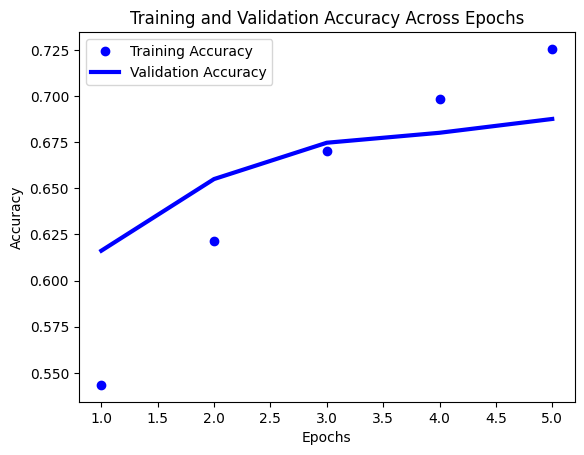

In [ ]:
plot_accuracy(fine_tuned_model_history)

225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 202ms/step
*************************
* Test Accuracy: 0.6739 *
*************************


,angry,disgust,fear,happy,sad,surprise,neutral
angry,692,13,40,20,107,11,75
disgust,47,45,1,3,9,1,5
fear,213,1,358,18,285,59,90
happy,53,2,21,1541,24,31,102
sad,184,8,60,34,742,8,211
surprise,64,0,71,34,35,584,43
neutral,98,1,28,49,179,3,875


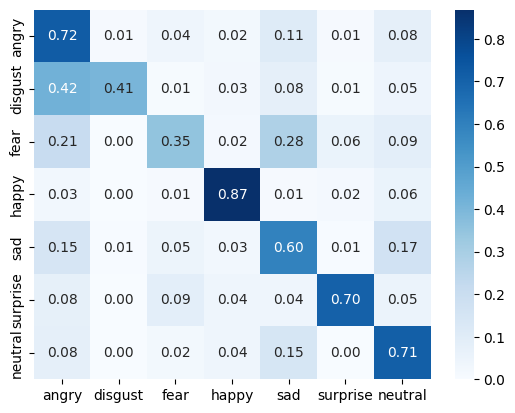

In [ ]:
show_confusion_matrix(fine_tuned_model)

Please comment briefly on the model's performance.  

<font color='red'> **Your Answer** </font>

Poor accuracy, except for certain areas

## Part (b): Fine-Tuning with Lower Learning Rate [10 points]
When fine-tuning a pre-trained model, it's often beneficial to use a lower learning rate to prevent destroying the useful pre-trained features. Let's try the same model but with a reduced learning rate.

In [ ]:
# Fresh instance of pre-trained backbone
backbone = keras_hub.models.Backbone.from_preset("vit_base_patch16_224_imagenet", load_weights=True)

# Create model with the same architecture
inputs = keras.Input(shape=(48, 48, 3), name="input")
#######################
x = data_augmentation(inputs)                             # Apply data augmentation
x = preprocessor(x)                                       # Preprocess input for ViT
x = backbone(x)[:, 0, :]                                  # Run through ViT backbone, select CLS embedding
x = keras.layers.Dense(256, activation="relu")(x)         # Run through a dense layer
outputs = keras.layers.Dense(7, activation="softmax")(x)  # Final classification layer

#######################
fine_tuned_model_lr = keras.Model(inputs, outputs, name='fine_tuned_vit_lower_lr')

In [ ]:
# Backbone is trainable
backbone.trainable = True

# Train with reduced learning rate
fine_tuned_model_lr.compile(
#######################
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), #changed
    loss="categorical_crossentropy",
    metrics=["accuracy"],
#######################
)

fine_tuned_model_lr_history = fine_tuned_model_lr.fit(
#######################
    train_faces,
    train_emotions,
    epochs=5,
    batch_size=64,
    validation_split=0.2
#######################
)

Epoch 1/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 691s 2s/step - accuracy: 0.2285 - loss: 1.9323 - val_accuracy: 0.2520 - val_loss: 1.7872
Epoch 2/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 693s 2s/step - accuracy: 0.2511 - loss: 1.7929 - val_accuracy: 0.2590 - val_loss: 1.7855
Epoch 3/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 693s 2s/step - accuracy: 0.2529 - loss: 1.7885 - val_accuracy: 0.2529 - val_loss: 1.7914
Epoch 4/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 691s 2s/step - accuracy: 0.2535 - loss: 1.7869 - val_accuracy: 0.2555 - val_loss: 1.7754
Epoch 5/5
359/359 ━━━━━━━━━━━━━━━━━━━━ 693s 2s/step - accuracy: 0.2527 - loss: 1.7877 - val_accuracy: 0.2529 - val_loss: 1.7934


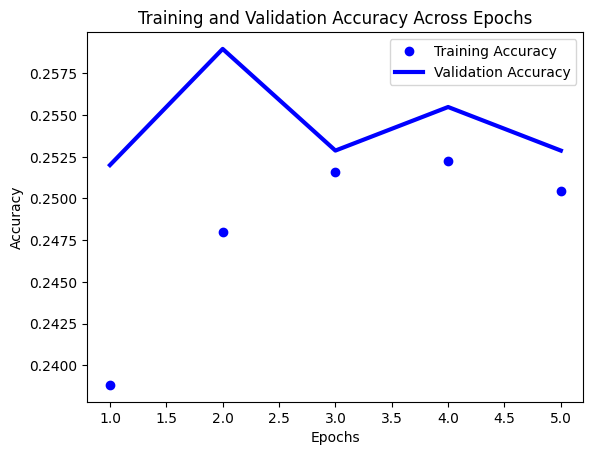

In [ ]:
plot_accuracy(fine_tuned_model_lr_history)

225/225 ━━━━━━━━━━━━━━━━━━━━ 50s 222ms/step - accuracy: 0.2465 - loss: 1.7997
Test accuracy: 0.2488
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 200ms/step
*************************
* Test Accuracy: 0.2488 *
*************************


,angry,disgust,fear,happy,sad,surprise,neutral
angry,0,0,0,949,9,0,0
disgust,0,0,0,111,0,0,0
fear,0,0,0,1017,7,0,0
happy,0,0,0,1765,9,0,0
sad,0,0,0,1226,21,0,0
surprise,0,0,0,829,2,0,0
neutral,0,0,0,1218,15,0,0


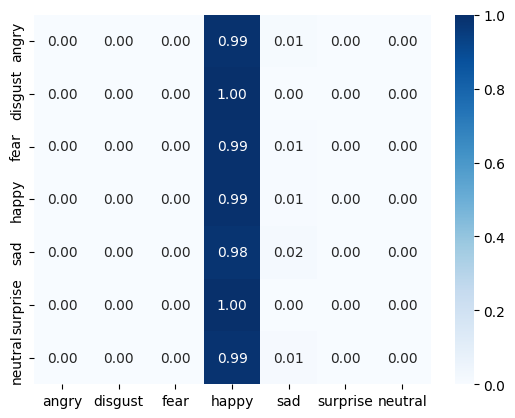

In [ ]:
# Calculate test accuracy
test_loss_fine_tuned_lr, test_accuracy_fine_tuned_lr = fine_tuned_model_lr.evaluate(test_faces, test_emotions)
print(f"Test accuracy: {test_accuracy_fine_tuned_lr:.4f}")

show_confusion_matrix(fine_tuned_model_lr)

Please comment on the results above.
Low accuracy

# Problem 3: Training from Scratch [10 Points]

In this final problem, we will build a Vision Transformer model with the same architecture but without using pre-trained weights. This will demonstrate the importance of transfer learning when working with limited data.

**Note:** Training a ViT from scratch is computationally expensive. We'll only train for 1 epoch to demonstrate the concept.

In [ ]:
# Load the ViT backbone WITHOUT pre-trained weights
backbone_scratch = keras_hub.models.Backbone.from_preset("vit_base_patch16_224_imagenet", load_weights=False)

# Create the model with the same architecture
#######################
x = data_augmentation(inputs)                             # Apply data augmentation
x = preprocessor(x)                                       # Preprocess input for ViT
x = backbone(x)[:, 0, :]                                  # Run through ViT backbone, select CLS embedding
x = keras.layers.Dense(256, activation="relu")(x)         # Run through a dense layer
outputs = keras.layers.Dense(7, activation="softmax")(x)  # Final classification layer

#######################
scratch_model = keras.Model(inputs, outputs, name='scratch_vit')
scratch_model.summary()

Model: "scratch_vit"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_image_classifier_preprocessor   │ (None, 224, 224, 3)         │               0 │
│ (ViTImageClassifierPreprocessor)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_backbone (ViTBackbone)          │ (None, 197, 768)            │      85,798,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_4 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,997,319 (328.05 MB)

 Trainable params: 85,997,319 (328.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train from scratch (for just 1 epoch to demonstrate)
scratch_model.compile(
#######################
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
#######################
)

# Smaller batch size may be needed due to memory constraints
scratch_model_history = scratch_model.fit(
#######################
    train_faces,
    train_emotions,
    epochs=1,
    batch_size=24,
    validation_split=0.2
#######################
)

# Calculate test accuracy
test_loss_scratch, test_accuracy_scratch = scratch_model.evaluate(test_faces, test_emotions)
print(f"Test accuracy after just 1 epoch: {test_accuracy_scratch:.4f}")

957/957 ━━━━━━━━━━━━━━━━━━━━ 1882s 2s/step - accuracy: 0.2424 - loss: 1.7992 - val_accuracy: 0.2635 - val_loss: 1.7689
225/225 ━━━━━━━━━━━━━━━━━━━━ 50s 222ms/step - accuracy: 0.2605 - loss: 1.7741
Test accuracy after just 1 epoch: 0.2654


Please comment on the results above. Low accuracy

# Problem 4: Overall Comparisons and Conceptual Understanding [30 Points]


## Comparison of All Models [20 points]

Compare the performance of all models we've trained.

Please discuss:
1. How does fine-tuning the backbone compare to just training the classification head?
2. What effect did lowering the learning rate have during fine-tuning?
3. Why does training from scratch perform so poorly? computer vision models with limited data?

<font color='red'>**Your Answer.**</font>

1. How does fine-tuning the backbone compare to just training the classification head? Fine-tuning leads to higher accuracy
2. What effect did lowering the learning rate have during fine-tuning? Leads to better final accuracy
3. Why does training from scratch perform so poorly? Lack of sufficient data
4. What are the practical implications of these results when developing computer vision models with limited data? Transfer learning is essential, lower learning rates improves fine-tuning stability, training from scratch is impractical for large datasets, pre-trained models save time and resources

# Conceptual Understanding [10 Points]
Answer the following conceptual questions with your own words - you can **avoid too many technical details**!

**Epochs and Batches.**

In your own words, please explain the relationship between an epoch and a batch in stochastic gradient descent.

<font color='red'>**Your Answer.**</font>

Epochs is the number of runs

Batch is the number of training samples

In SGD, model updates after each batch rather than full pass, thus a relationship can be drawn of batches per epoch which is training samples divided by batch size



When we ran `model.fit`, we saw that there are 359 batches per epoch. Please explain how this 359 is calculated. _Hint_: There are 28,709 training data points and 20% is set aside for validation.

<font color='red'>**Your Answer.**</font>

Training Samples=28,709×(1−0.2)=28,709×0.8=22,967

Total Training Samples / Batch Size = 22,967 / 64 = 359
